# Model Creation

## Load the data and convert it into a format the network can understand

In [56]:
import pandas as pd

# Load the dataframes
song_metadata_df = pd.read_csv('data/preprocessed-data/song_metadata.csv')
song_sentiment_df = pd.read_csv('data/preprocessed-data/song_sentiment.csv')
song_lyrics_df = pd.read_csv('data/preprocessed-data/song_lyrics.csv')
song_lyrics_tokenized = pd.read_csv('data/processed-data/song_lyrics_tokenized.csv')

# Numeric features from song_sentiment_df
numeric_features_df = song_sentiment_df[['valence', 'danceability', 'energy', 'tempo', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']]
num_numeric_features = numeric_features_df.shape[1]

# Genre features from song_metadata_df (One-hot encode genres)
genres_df = pd.get_dummies(song_metadata_df['genre'])
num_genres = genres_df.shape[1]

In [58]:
from collections import Counter
import numpy as np

# Flatten all the tokenized lyrics into one large list
all_lyrics = [word for sublist in song_lyrics_tokenized['tokenized_lyrics'].str.split() for word in sublist]

# Create a counter of all words
word_counter = Counter(all_lyrics)

# Create a vocabulary and assign an index to each word
vocab = {word: i + 1 for i, (word, _) in enumerate(word_counter.most_common())}  # start indexing from 1
vocab['<PAD>'] = 0  # PAD token

# vocab_size is the total number of unique tokens in your corpus
vocab_size = len(vocab)

In [59]:
# Convert the lyrics to sequences of integers
sequences = [[vocab[word] for word in lyric.split()] for lyric in song_lyrics_tokenized['tokenized_lyrics']]

# Define a function for padding sequences
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) < maxlen:
            padded_sequences[i, -len(seq):] = seq
        else:
            padded_sequences[i, :] = seq[:maxlen]
    return padded_sequences

# Pad sequences
sequence_length = 50
X_train_seq = pad_sequences(sequences, maxlen=sequence_length)

# Extract labels (you might want to convert these to one-hot encodings)
y_train = np.array([seq[-1] for seq in sequences])

In [60]:
from sklearn.preprocessing import MinMaxScaler

# Normalize numeric features
scaler = MinMaxScaler()
X_train_num = scaler.fit_transform(numeric_features_df)

# Prepare genre data
X_train_cat = genres_df.values

In [61]:
assert len(X_train_seq) == len(X_train_num) == len(X_train_cat) == len(y_train), "Mismatch in dataset lengths."

## Define the Model

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class LyricsGeneratorModel(nn.Module):
    def __init__(self, vocab_size, num_genres, num_numeric_features):
        super(LyricsGeneratorModel, self).__init__()
        # Define the layers and their dimensions
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(128, 128, batch_first=True)
        self.dense_numeric = nn.Linear(num_numeric_features, 32)
        self.dense_genre = nn.Linear(num_genres, 32)
        self.dense_combined = nn.Linear(128 + 32 + 32, 128)
        self.output_layer = nn.Linear(128, vocab_size)

    def forward(self, lyrics_input, numeric_input, genre_input):
        # Define the forward pass
        embedded_lyrics = self.embedding(lyrics_input)
        lstm_out, _ = self.lstm(embedded_lyrics)
        lstm_out = lstm_out[:, -1, :]  # Get the output of the last LSTM cell

        numeric_out = F.relu(self.dense_numeric(numeric_input))
        genre_out = F.relu(self.dense_genre(genre_input))

        combined = torch.cat((lstm_out, numeric_out, genre_out), dim=1)
        combined = F.relu(self.dense_combined(combined))
        output = self.output_layer(combined)
        return output

## Dataloader

In [63]:
class LyricsDataset(Dataset):
    def __init__(self, lyrics_sequences, numeric_features, genre_features, labels):
        self.lyrics_sequences = lyrics_sequences
        self.numeric_features = numeric_features
        self.genre_features = genre_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.lyrics_sequences[idx], self.numeric_features[idx], self.genre_features[idx], self.labels[idx]

# Convert your preprocessed data to PyTorch tensors and create a dataset
train_dataset = LyricsDataset(X_train_seq, X_train_num, X_train_cat, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


## Training

Epoch 1/30: 100%|██████████| 199/199 [00:17<00:00, 11.32it/s]


Epoch 1/30, Average Loss: 7.853093707980822


Epoch 2/30: 100%|██████████| 199/199 [00:16<00:00, 11.80it/s]


Epoch 2/30, Average Loss: 6.414848960224708


Epoch 3/30: 100%|██████████| 199/199 [00:16<00:00, 11.90it/s]


Epoch 3/30, Average Loss: 6.227576092859009


Epoch 4/30: 100%|██████████| 199/199 [00:20<00:00,  9.70it/s]


Epoch 4/30, Average Loss: 6.115018075435006


Epoch 5/30: 100%|██████████| 199/199 [00:29<00:00,  6.84it/s]


Epoch 5/30, Average Loss: 5.966381288653043


Epoch 6/30: 100%|██████████| 199/199 [00:21<00:00,  9.10it/s]


Epoch 6/30, Average Loss: 5.761180743500216


Epoch 7/30: 100%|██████████| 199/199 [00:18<00:00, 10.49it/s]


Epoch 7/30, Average Loss: 5.494866356777785


Epoch 8/30: 100%|██████████| 199/199 [00:17<00:00, 11.09it/s]


Epoch 8/30, Average Loss: 5.189944892672438


Epoch 9/30: 100%|██████████| 199/199 [00:17<00:00, 11.34it/s]


Epoch 9/30, Average Loss: 4.826535942566455


Epoch 10/30: 100%|██████████| 199/199 [00:17<00:00, 11.20it/s]


Epoch 10/30, Average Loss: 4.397998267082713


Epoch 11/30: 100%|██████████| 199/199 [00:18<00:00, 10.93it/s]


Epoch 11/30, Average Loss: 3.9032168939485024


Epoch 12/30: 100%|██████████| 199/199 [00:18<00:00, 10.87it/s]


Epoch 12/30, Average Loss: 3.338624048472649


Epoch 13/30: 100%|██████████| 199/199 [00:18<00:00, 10.80it/s]


Epoch 13/30, Average Loss: 2.699718259087759


Epoch 14/30: 100%|██████████| 199/199 [00:19<00:00, 10.22it/s]


Epoch 14/30, Average Loss: 2.060391099608723


Epoch 15/30: 100%|██████████| 199/199 [00:19<00:00, 10.31it/s]


Epoch 15/30, Average Loss: 1.4906671032234653


Epoch 16/30: 100%|██████████| 199/199 [00:18<00:00, 11.00it/s]


Epoch 16/30, Average Loss: 1.0690631405193003


Epoch 17/30: 100%|██████████| 199/199 [00:19<00:00, 10.05it/s]


Epoch 17/30, Average Loss: 0.7471100253675451


Epoch 18/30: 100%|██████████| 199/199 [00:19<00:00,  9.98it/s]


Epoch 18/30, Average Loss: 0.5211642577720048


Epoch 19/30: 100%|██████████| 199/199 [00:19<00:00, 10.34it/s]


Epoch 19/30, Average Loss: 0.341743405477785


Epoch 20/30: 100%|██████████| 199/199 [00:18<00:00, 10.48it/s]


Epoch 20/30, Average Loss: 0.22634980434448876


Epoch 21/30: 100%|██████████| 199/199 [00:18<00:00, 10.84it/s]


Epoch 21/30, Average Loss: 0.14669074193017567


Epoch 22/30: 100%|██████████| 199/199 [00:18<00:00, 11.00it/s]


Epoch 22/30, Average Loss: 0.08912356605931143


Epoch 23/30: 100%|██████████| 199/199 [00:17<00:00, 11.16it/s]


Epoch 23/30, Average Loss: 0.0580937937182847


Epoch 24/30: 100%|██████████| 199/199 [00:17<00:00, 11.23it/s]


Epoch 24/30, Average Loss: 0.038142576682657456


Epoch 25/30: 100%|██████████| 199/199 [00:17<00:00, 11.35it/s]


Epoch 25/30, Average Loss: 0.02488745118598992


Epoch 26/30: 100%|██████████| 199/199 [00:17<00:00, 11.43it/s]


Epoch 26/30, Average Loss: 0.018097190331461743


Epoch 27/30: 100%|██████████| 199/199 [00:17<00:00, 11.46it/s]


Epoch 27/30, Average Loss: 0.014009777828583016


Epoch 28/30: 100%|██████████| 199/199 [00:18<00:00, 11.01it/s]


Epoch 28/30, Average Loss: 0.011333165844743276


Epoch 29/30: 100%|██████████| 199/199 [00:18<00:00, 10.90it/s]


Epoch 29/30, Average Loss: 0.00932857975242051


Epoch 30/30: 100%|██████████| 199/199 [00:18<00:00, 10.64it/s]

Epoch 30/30, Average Loss: 0.007713646298021677


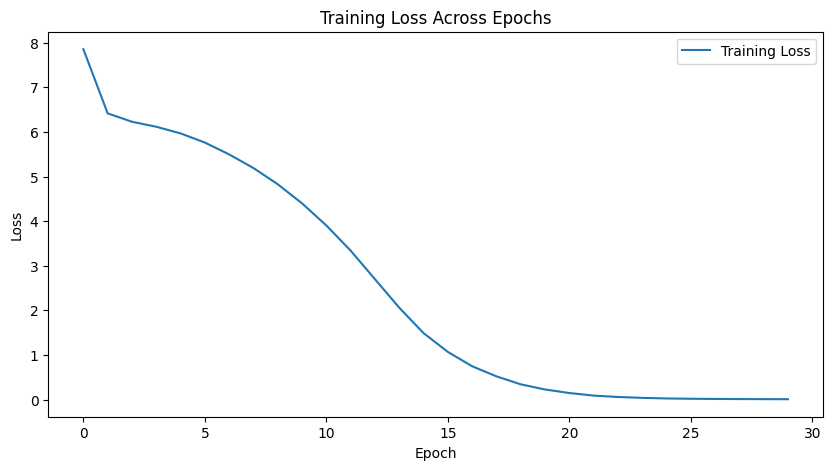

In [66]:
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LyricsGeneratorModel(vocab_size, num_genres, num_numeric_features).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    # Wrap your training loader with tqdm for a progress bar
    for lyrics, numeric, genre, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lyrics, numeric, genre, labels = lyrics.long().to(device), numeric.float().to(device), genre.float().to(device), labels.long().to(device)

        optimizer.zero_grad()
        outputs = model(lyrics, numeric, genre)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}')

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save the model and its loss

In [ ]:
import os
import matplotlib.pyplot as plt
model_name = 'basic_lyrics_generator'

# Save the model
model_save_path = os.path.join(f"models/{model_name}", f'{model_name}.pth')
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

# Save the loss plot as an image
loss_plot_path = os.path.join(f"models/{model_name}", f'{model_name}_training_loss.png')
plt.savefig(loss_plot_path)
plt.close()  # Close the plot to avoid displaying it in the notebook/console
print(f'Loss plot saved to {loss_plot_path}')

Model saved to models/basic_lyrics_generator/basic_lyrics_generator.pth
Loss plot saved to models/basic_lyrics_generator/basic_lyrics_generator_training_loss.png


# Model Evaluation

## Tokenization functions & genre to numeric function

In [96]:
import re
# NOTE: Musical feature number is preserved in the tokenization process
features_pattern = "(coro|pre-coro|outro|instrumental intro|intro|verso \d+|hook|post-chorus \d+|verso|chorus \d+|verse|interlude \d+|instrumental outro|pre-coro \d+|break|bridge|instrumental|instrumental break|outro \d+|interlude|break \d+|saxophone solo|instrumental interlude|refrain|bridge \d+|coro \d+|intro \d+|pre-chorus|pre-chorus \d+|chorus|hook \d+|verse \d+|instrumental bridge|spoken|refrain \d+|guitar solo|post-chorus|breakdown|solo)"
def tokenize_lyrics(lyrics):
    # Converting to lowercase
    lyrics = lyrics.lower()

    # Removing artist names from musical features
    lyrics = re.sub(fr"\[{features_pattern}:?[^\]]*?\]", r"[\1]", lyrics)

    # Splitting the lyrics into lines
    lines = lyrics.split('\n')

    # Tokenizing each line
    tokens = []
    for line in lines:
        # Check and skip the [?] token
        if '[?]' in line:
            line = re.sub(r"\[\?\]", "", line)  # Ignore the [?] token

        # Tokenizing special tokens like [x2] as "[x2]"
        if '[x2]' in line:
            tokens.append("[x2]")
            line = re.sub(r"\[x2\]", "", line)  # Remove the special token from the line

        # Tokenizing musical features as separate tokens, including those with numbers
        musical_features = re.findall(fr"\[{features_pattern}(?:\]|:[^\]]*\])", line)
        if musical_features:
            for feature in musical_features:
                # Capitalize the first letter of each word and add square brackets
                capitalized_feature = '[' + ' '.join(word.capitalize() for word in feature.split()) + ']'
                tokens.append(capitalized_feature)
            line = re.sub(fr"\[.*?\]", "", line).strip()

        # Tokenizing words, standalone punctuation, and ellipses as separate tokens
        # Added a pattern to capture ellipses before individual periods
        line_tokens = re.findall(r"\.{3}|[\w’']+(?:-[a-z’']+)?|[.,!?;]", line)
        tokens.extend(line_tokens)

        # Adding a token for line breaks
        tokens.append("\n")

    # Removing the last line break token
    if tokens and tokens[-1] == "\n":
        tokens.pop()

    return tokens

def detokenize_lyrics(tokenized_lyrics):
    return ''.join(f'{s} ' if i < len(tokenized_lyrics) - 1 and s != '\n' and tokenized_lyrics[i + 1] != '\n' else s for i, s in enumerate(tokenized_lyrics)).strip()

In [109]:
def genre_to_numeric(genre_name):
    """
    Convert a genre name to its corresponding numeric representation (one-hot encoded vector).
    
    :param genre_name: The name of the genre as a string.
    :return: A one-hot encoded numeric representation of the genre as a list.
    """
    if genre_name in genres_df.columns:
        # Create a zero-filled list with length equal to the number of genres
        numeric_representation = np.zeros((1, num_genres))
        
        # Find the index of the genre and set it to 1 in the numeric representation
        index = list(genres_df.columns).index(genre_name)
        numeric_representation[0, index] = 1
        
        return numeric_representation
    else:
        # Print an error message if the genre isn't found
        print(f"Error: The genre '{genre_name}' was not found in the dataset.")
        return None  # Return None or handle this case as you see fit

# Example usage:
genre_name = "rap"  # Replace with the genre you want to convert
numeric_representation = genre_to_numeric(genre_name)

if numeric_representation is not None:
    print(f"The numeric representation of '{genre_name}' is:", numeric_representation)

The numeric representation of 'rap' is: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Lyric Generation

In [110]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_lyrics(model, seed_text, vocab, numeric_tensor, genre_tensor, max_sequence_len=100, generation_length=50):
    model.eval()  # Set the model to evaluation mode

    # Tokenize the seed text
    tokenized_seed_text = tokenize_lyrics(seed_text)

    generated_tokens = tokenized_seed_text  # Start with the tokenized seed text

    for _ in range(generation_length):
        # print(generated_tokens)
        # Convert the tokenized text to a sequence of indices
        token_list = [vocab.get(word, 0) for word in generated_tokens]  # 0 is the index for unknown words
        token_list = pad_sequences([token_list], maxlen=max_sequence_len)  # Pad the sequence
        token_list = torch.tensor(token_list, dtype=torch.long).to(device)

        # Predict the next word (as a token)
        with torch.no_grad():
            predictions = model(token_list, numeric_tensor, genre_tensor).cpu()
        predicted_token = torch.argmax(predictions, dim=1)[-1].item()

        # Find the word corresponding to the predicted token
        # Create a reverse vocabulary for lookup
        reverse_vocab = {index: word for word, index in vocab.items()}
        predicted_word = reverse_vocab.get(predicted_token, '<UNK>')  # Use '<UNK>' for unknown words

        # Append the predicted word to the generated tokens
        generated_tokens.append(predicted_word)

    # Detokenize the generated lyrics
    generated_text = detokenize_lyrics(generated_tokens)

    return generated_text


## Test the generation of lyric

In [2]:
import numpy as np
# Define specific numeric and genre inputs
# Example numeric features - replace with actual desired values
specific_numeric = np.array([[0.5, 0.6, 0.7, 120, -5, 0.1, 0.2, 0.01, 0.3]])
# Normalize the specific numeric features
specific_numeric = scaler.transform(specific_numeric)  # Assuming 'scaler' is MinMaxScaler fitted on your numeric data

# Example genre input - replace with the actual one-hot encoded vector for the desired genre
specific_genre = genre_to_numeric("rock")

# Convert to tensors
specific_numeric_tensor = torch.tensor(specific_numeric, dtype=torch.float)
specific_genre_tensor = torch.tensor(specific_genre, dtype=torch.float)

# Test cases
def run_test_cases():
    test_cases = [
        "[Intro]",
        "Yo, left, yo, left",
        "In the middle of the night",
        "Hello",
        "xyz abcdefgh unknownword",
        "word " * 150,
        "Life is beautiful, isn't it? #wonderful @life",
        "In the year 2020, something happened",
        "sldkfj slkdjflskj dflskjdf lskdjf",
        "Silent whispers in the",
        "echo echo echo echo echo"
    ]

    generation_lengths = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]  # Adjust lengths as needed

    for i, seed_text in enumerate(test_cases):
        print(f"Test {i + 1} - Seed Text: '{seed_text[:30]}...'")  # Print the first 30 chars of the seed text
        generated_text = generate_lyrics(model, seed_text, vocab, specific_numeric_tensor, specific_genre_tensor, generation_length=generation_lengths[i])
        print("Generated Lyrics:", generated_text, "\n\n")

# Run all test cases
run_test_cases()

def genre_to_numeric(genre_name):
    """
    Convert a genre name to its corresponding numeric representation (one-hot encoded vector).
    
    :param genre_name: The name of the genre as a string.
    :return: A one-hot encoded numeric representation of the genre as a list.
    """
    if genre_name in genres_df.columns:
        # Create a zero-filled list with length equal to the number of genres
        numeric_representation = [0] * len(genres_df.columns)
        
        # Find the index of the genre and set it to 1 in the numeric representation
        index = list(genres_df.columns).index(genre_name)
        numeric_representation[index] = 1
        
        return numeric_representation
    else:
        # Print an error message if the genre isn't found
        print(f"Error: The genre '{genre_name}' was not found in the dataset.")
        return None  # Return None or handle this case as you see fit


/usr/local/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
warnings.warn(
Test 1 - Seed Text: '[Intro]...'
Generated Lyrics: [Intro] back back back back claire fuck hand out out out out out here fly feel feeling innocent music oooooo soul na song yeah ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !


Test 2 - Seed Text: 'Yo, left, yo, left...'
Generated Lyrics: yo , left , yo , left  back back back back claire fuck hand out out out out out here fly feel feeling innocent music oooooo soul na song yeah ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !


Test 3 - Seed Text: 'In the middle of the night...'
Generated Lyrics: in the middle of the night back back back back claire fuck hand out out out out out here fly feel feeling innocent music oooooo soul na song yeah ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !


Test 4 - Seed Text: 'Hello...'
Generated Lyrics: hello back back back ba